# Skin cancer image classification

the dataset would be downloaded throught kaggle, to complete this step i had download my kaggle API and upload it to the google colab note book i am using. The next step was to create a folder named kaggle and set the security preference. after doing this step we can download the *ISIC 2018 skin legion dataset* and unzip it. the dataset contains other folders like it's metadata and is 5gb large.

In [6]:
#!pip install kaggle

In [7]:
#!pip install kaggle

In [8]:
#!cp kaggle.json ~/.kaggle/

In [9]:
#!chmod 600 ~/.kaggle/kaggle.json

In [10]:
#! kaggle datasets download kmader/skin-cancer-mnist-ham10000

In [11]:
#!unzip skin-cancer-mnist-ham10000.zip

## Loading in libraries and path

In [3]:
import os
from glob import glob
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

base_dir = os.path.join('../skin-legion-deep-learning-project-/Data')

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
print('Tf-version:', tf.__version__)

print("GPU","Yes Available" if tf.test.is_gpu_available() else "not Available")

Tf-version: 2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

GPU Yes Available


2022-12-04 03:13:36.913786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 03:13:36.914334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# lesion_type_dict = {
#     'nv': 'Melanocytic nevi',
#     'mel': 'Melanoma',
#     'bkl': 'Benign keratosis-like lesions ',
#     'bcc': 'Basal cell carcinoma',
#     'akiec': 'Actinic keratoses',
#     'vasc': 'Vascular lesions',
#     'df': 'Dermatofibroma'
# }

In [6]:
import pandas as pd

In [7]:
lesion_type_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'vasc': 'Vascular lesions'
}

In [8]:
class_names = ['Actinic keratoses','Basal cell carcinoma',
               'Benign keratosis-like lesions ', 'Dermatofibroma', 
               'Melanocytic nevi','Melanoma', 'Vascular lesions'
        ]

In [9]:
tile_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,cell_type_idx
2979,HAM_0007567,ISIC_0031588,nv,follow_up,45.0,female,lower extremity,Melanocytic nevi,../skin-legion-deep-learning-project-/Data/HAM...,4
3867,HAM_0000608,ISIC_0025756,nv,follow_up,30.0,female,foot,Melanocytic nevi,../skin-legion-deep-learning-project-/Data/HAM...,4
7037,HAM_0006856,ISIC_0028831,nv,histo,35.0,male,chest,Melanocytic nevi,../skin-legion-deep-learning-project-/Data/HAM...,4


In [13]:
tile_df['cell_type'].unique()

array(['Benign keratosis-like lesions', 'Melanocytic nevi',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [14]:
# load in all of the images
tile_df['image'] = tile_df['path'].map(imread)

In [113]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    10015
Name: image, dtype: int64

In [112]:
tile_df[['cell_type_idx', 'cell_type']].sort_values('cell_type_idx').drop_duplicates()

,cell_type_idx,cell_type
9804,0,Actinic keratoses
2528,1,Basal cell carcinoma
1018,2,Benign keratosis-like lesions
1159,3,Dermatofibroma
7050,4,Melanocytic nevi
1622,5,Melanoma
2413,6,Vascular lesions


In [9]:
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [9]:
tile_df['cell_type'].unique()

array(['Benign keratosis-like lesions ', 'Melanocytic nevi',
       'Dermatofibroma', 'Melanoma', 'Vascular lesions',
       'Basal cell carcinoma', 'Actinic keratoses'], dtype=object)

In [52]:
tile_df['cell_type'].value_counts()

Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: cell_type, dtype: int64

## converting the size of the image dataset

because the dataset is 450 in height and 600 in width and in RGB format, i would like to downscale the size to help in reducing training time on the GPU

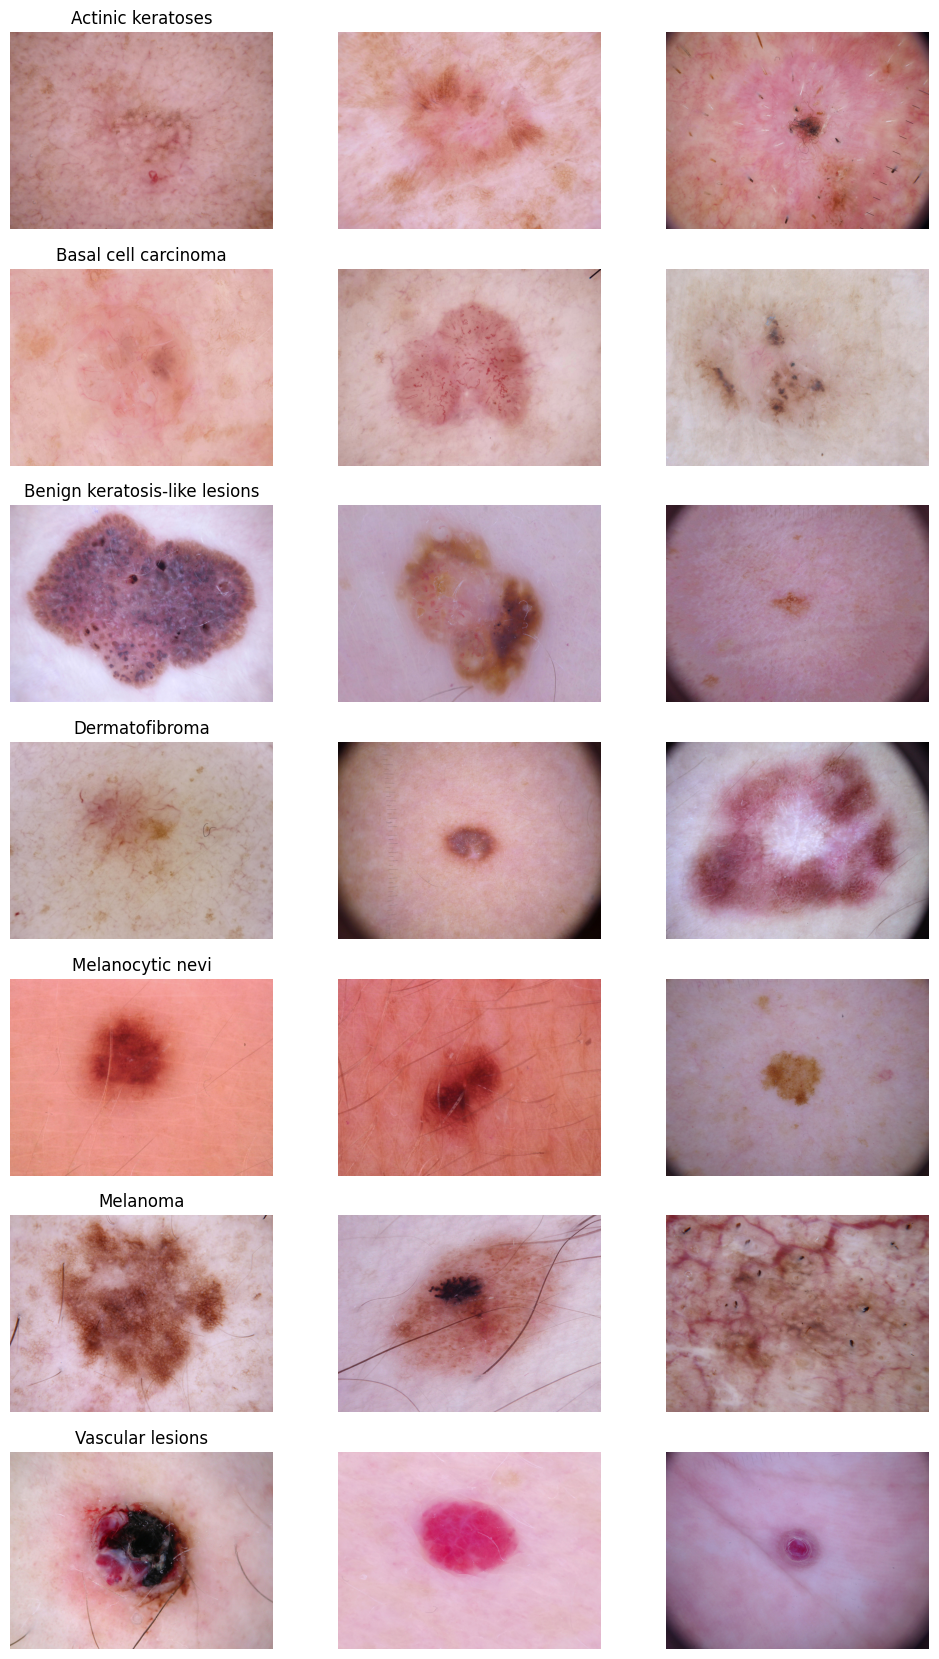

In [16]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [10]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    10015
Name: image, dtype: int64

In [109]:
tile_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../skin-legion-deep-learning-project-/Data/HAM...,2,"[[[188, 147, 191], [186, 148, 189], [187, 150,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../skin-legion-deep-learning-project-/Data/HAM...,2,"[[[25, 15, 23], [25, 14, 22], [25, 14, 22], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,../skin-legion-deep-learning-project-/Data/HAM...,2,"[[[186, 128, 140], [188, 128, 136], [183, 126,..."


In [78]:
tile_df['cell_type'].count

<bound method Series.count of 0        Benign keratosis-like lesions 
1        Benign keratosis-like lesions 
2        Benign keratosis-like lesions 
3        Benign keratosis-like lesions 
4        Benign keratosis-like lesions 
                      ...              
10010                 Actinic keratoses
10011                 Actinic keratoses
10012                 Actinic keratoses
10013                 Actinic keratoses
10014                          Melanoma
Name: cell_type, Length: 10015, dtype: object>

In [27]:
tile_df.dtypes

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
cell_type         object
path              object
cell_type_idx       int8
image             object
dtype: object

In [28]:
tile_df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


# DATA CLEANING

In [11]:
tile_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
cell_type         0
path              0
cell_type_idx     0
image             0
dtype: int64

<AxesSubplot: >

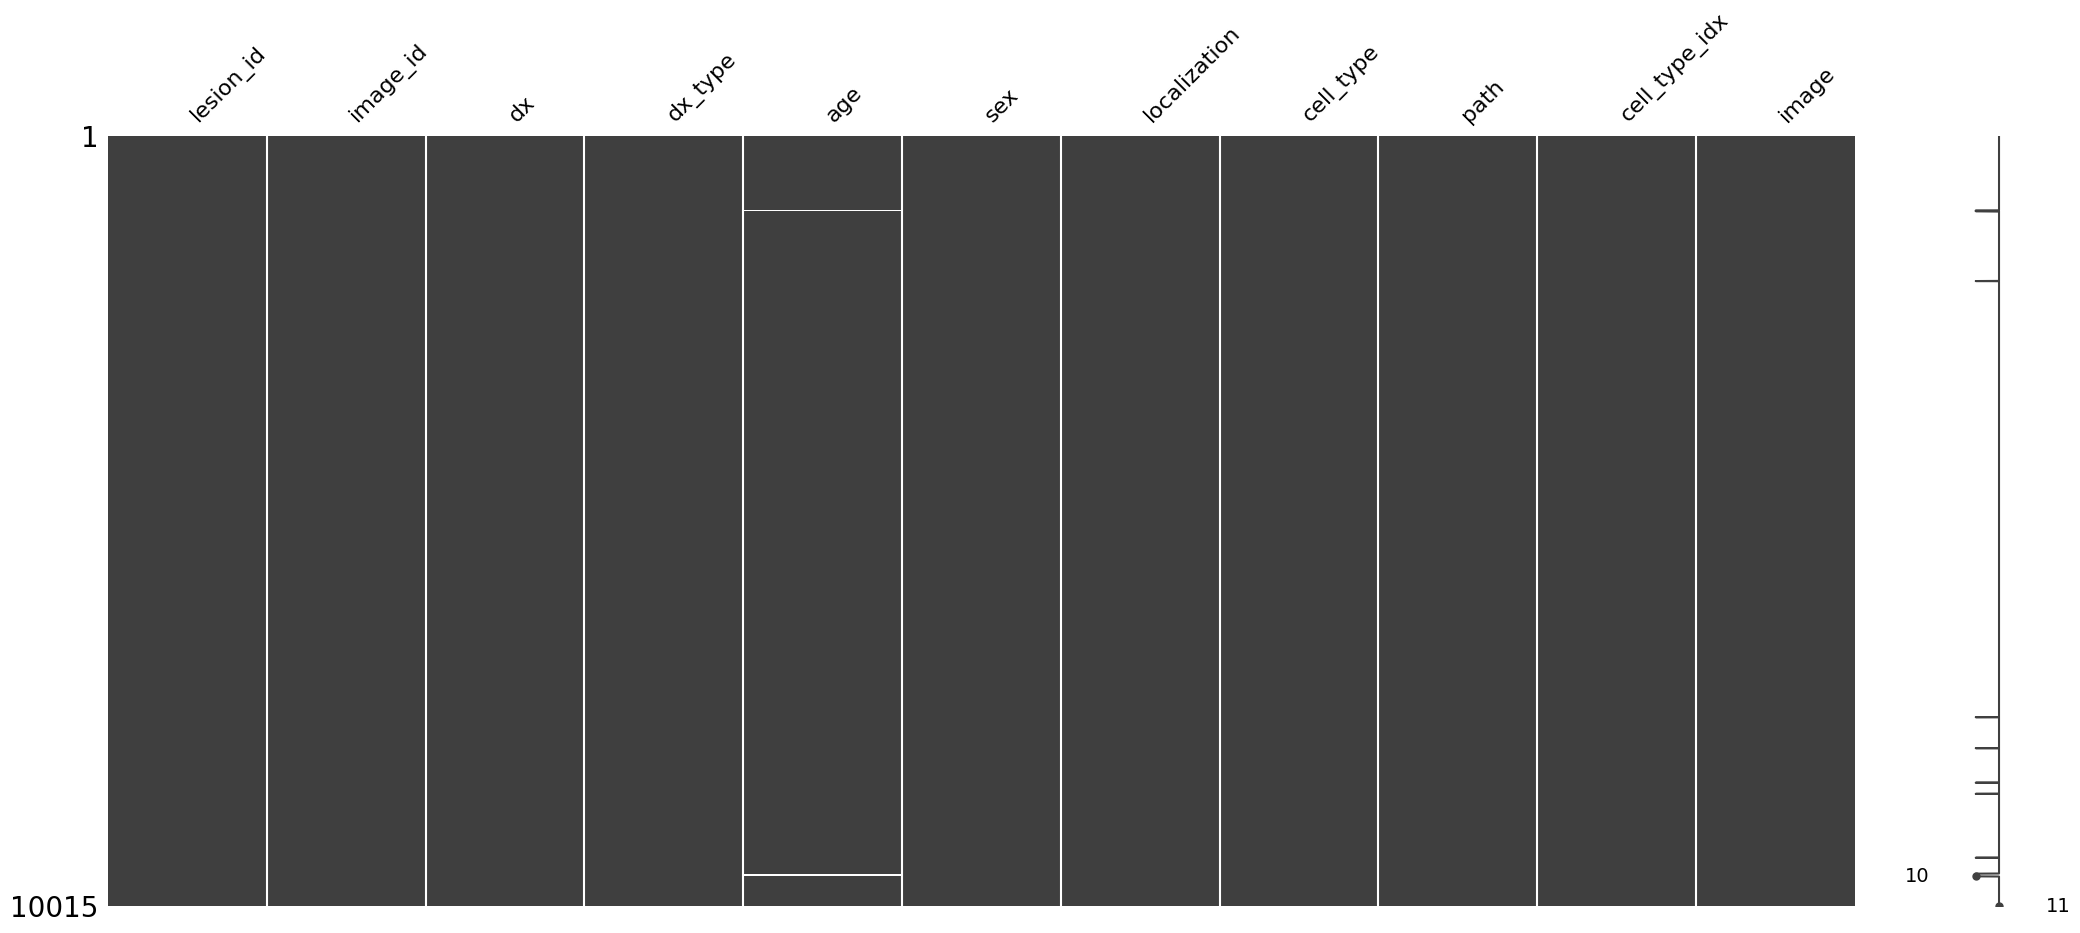

In [12]:
import missingno as msno
msno.matrix(tile_df)

In [13]:
tile_df['age'].fillna(int(tile_df['age'].mean()),inplace=True)

In [14]:
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
cell_type        0
path             0
cell_type_idx    0
image            0
dtype: int64

In [87]:
tile_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

# UNIVARIATE ANALYSIS

<AxesSubplot: title={'center': 'CELL TYPE'}, ylabel='Count'>

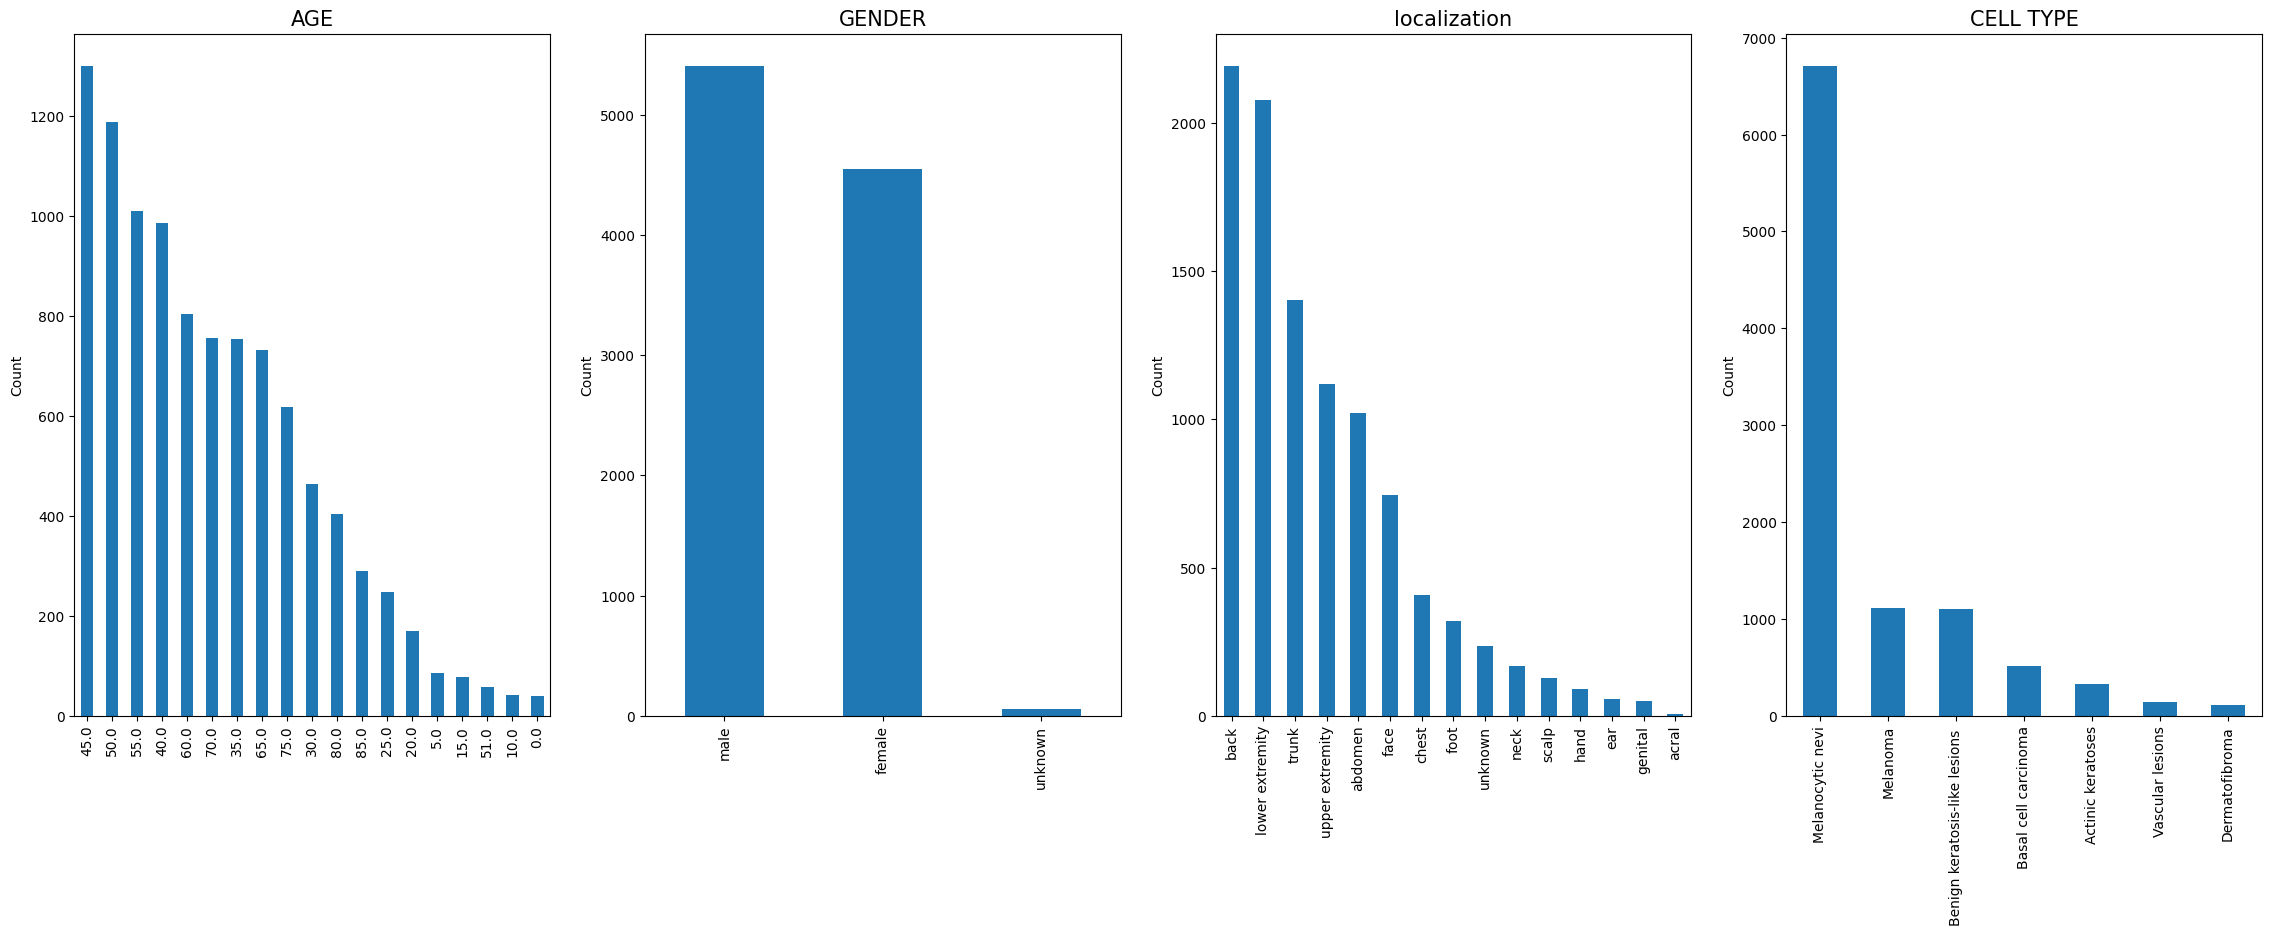

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,15))
plt.subplots_adjust(left=0.125, bottom=1, right=1.0, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
tile_df['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
tile_df['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
tile_df['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
tile_df['cell_type'].value_counts().plot.bar()

In [34]:
tile_df["cell_type_idx"].unique()

array([2, 4, 3, 5, 6, 1, 0], dtype=int8)

In [35]:
import seaborn as sns

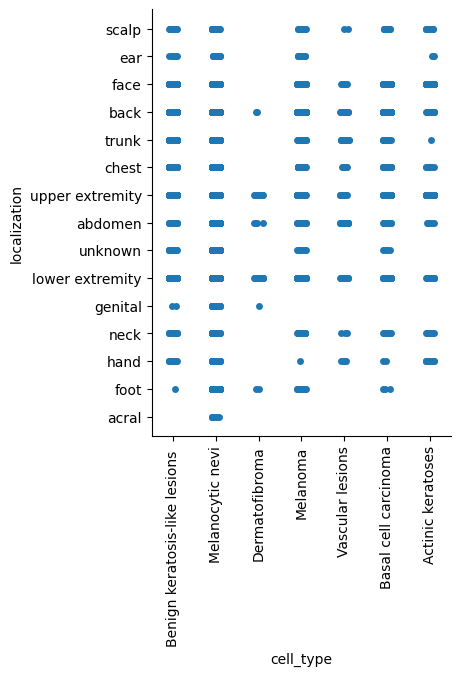

In [36]:
a=sns.catplot(data=tile_df, x="cell_type", y="localization")
a.set_xticklabels(rotation=90)

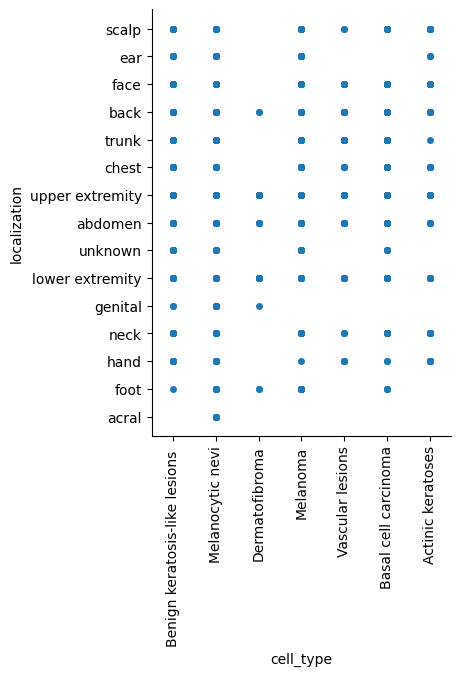

In [37]:
b=sns.catplot(data=tile_df, x="cell_type", y="localization", jitter=False)
b.set_xticklabels(rotation=90)

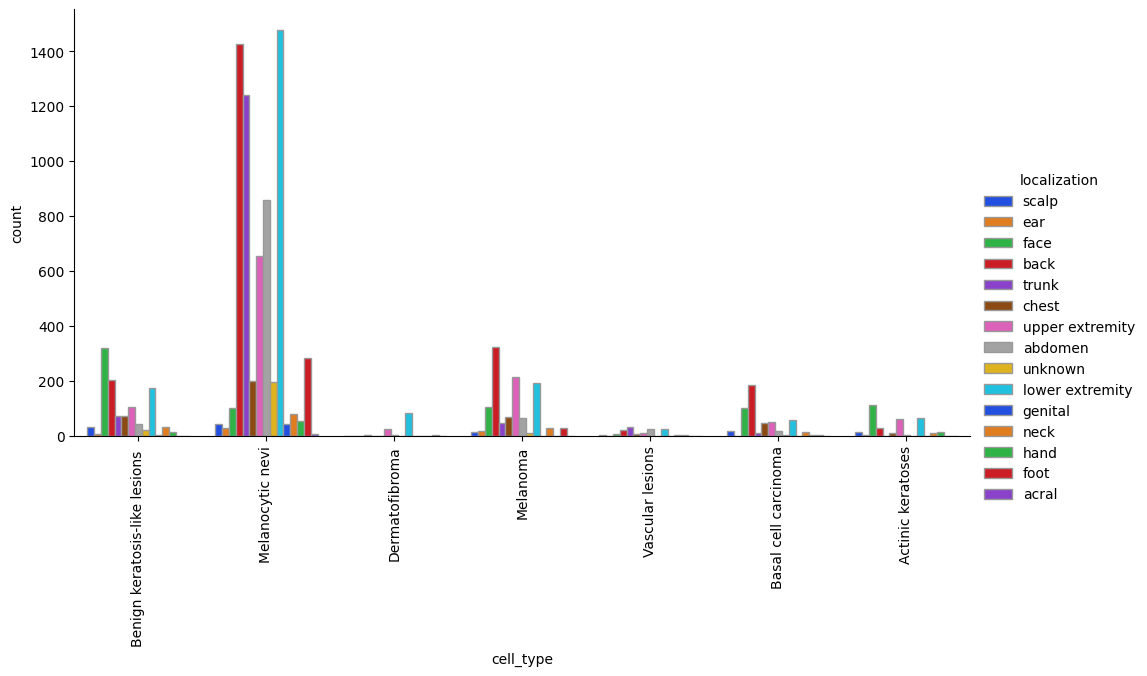

In [38]:
sns.catplot(
    data=tile_df, x="cell_type", hue="localization", kind = 'count',
    palette="bright", edgecolor=".6",height=5, aspect=10/5
).set_xticklabels(rotation=90)


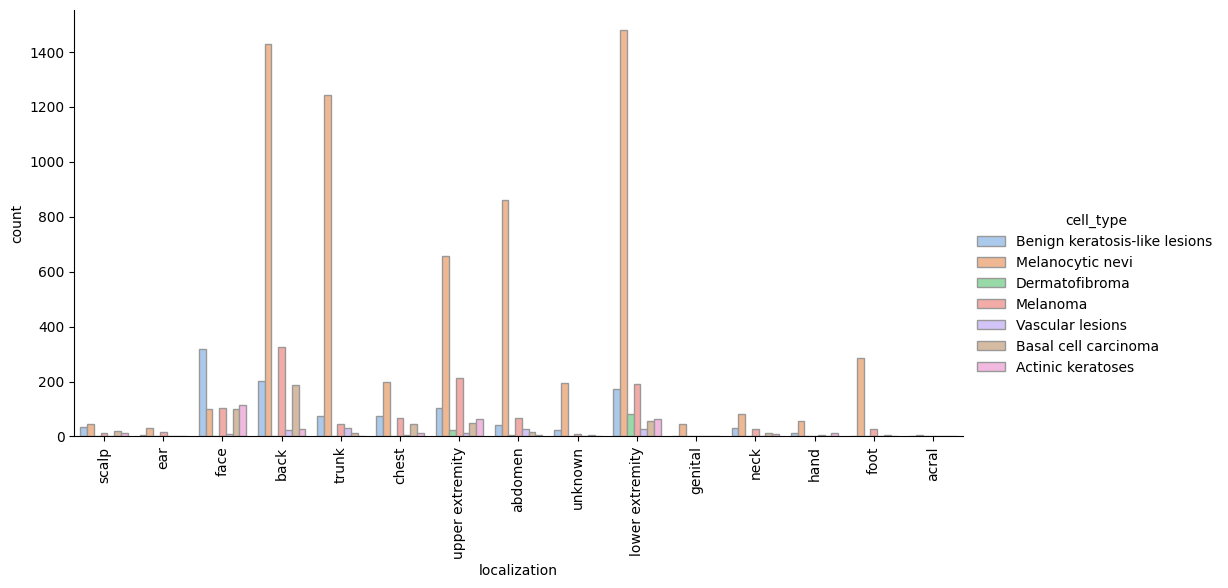

In [39]:
sns.catplot(
    data=tile_df, x="localization", hue="cell_type", kind = 'count',
    palette="pastel", edgecolor=".6",height=5, aspect=10/5
).set_xticklabels(rotation=90)

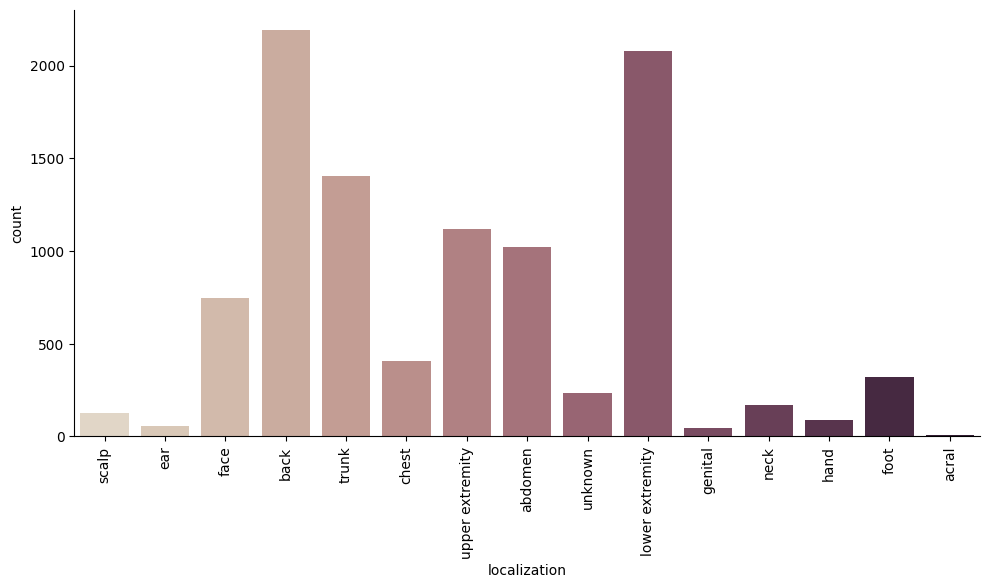

In [40]:

sns.catplot(data=tile_df, x="localization", kind="count", palette="ch:.25", height=5, aspect=10/5).set_xticklabels(rotation=90)

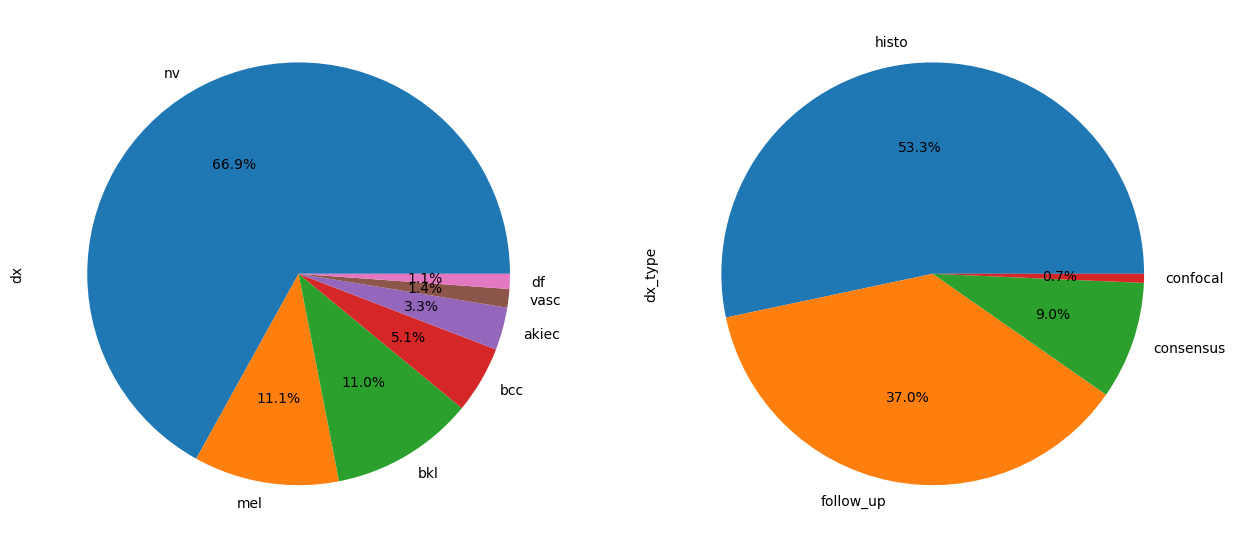

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
tile_df['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
tile_df['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

<AxesSubplot: title={'center': 'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

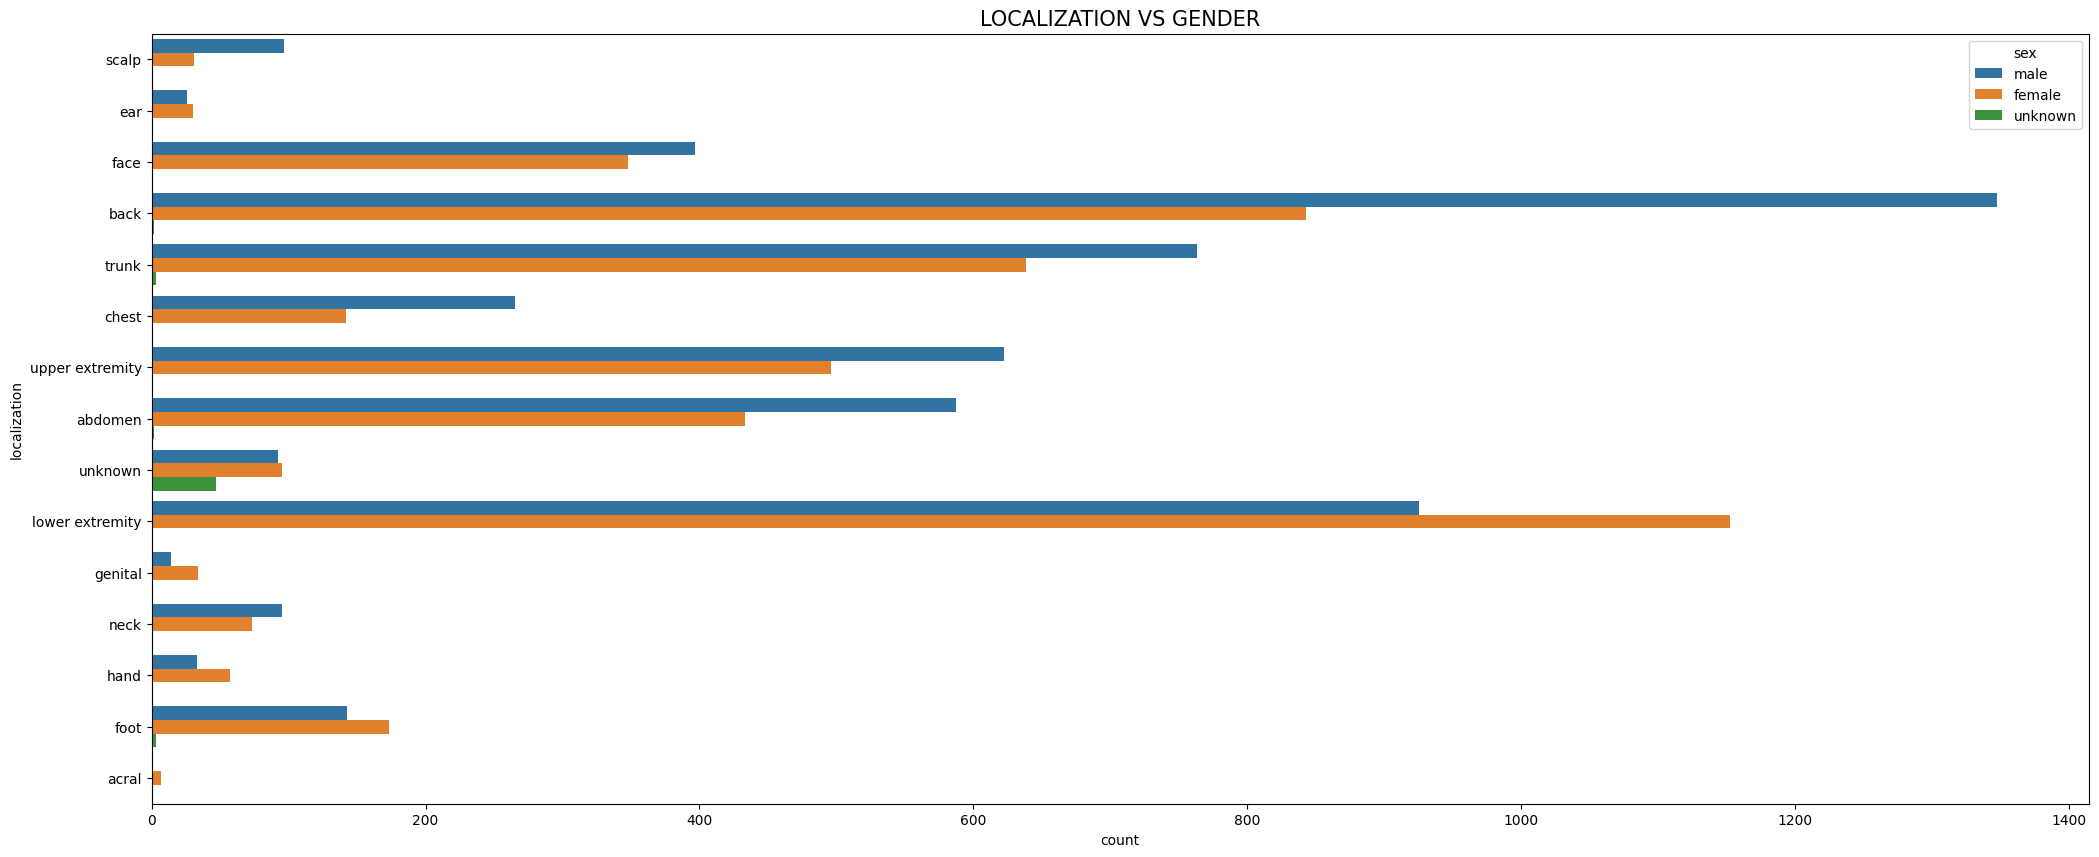

In [42]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=tile_df)

<AxesSubplot: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='localization', ylabel='count'>

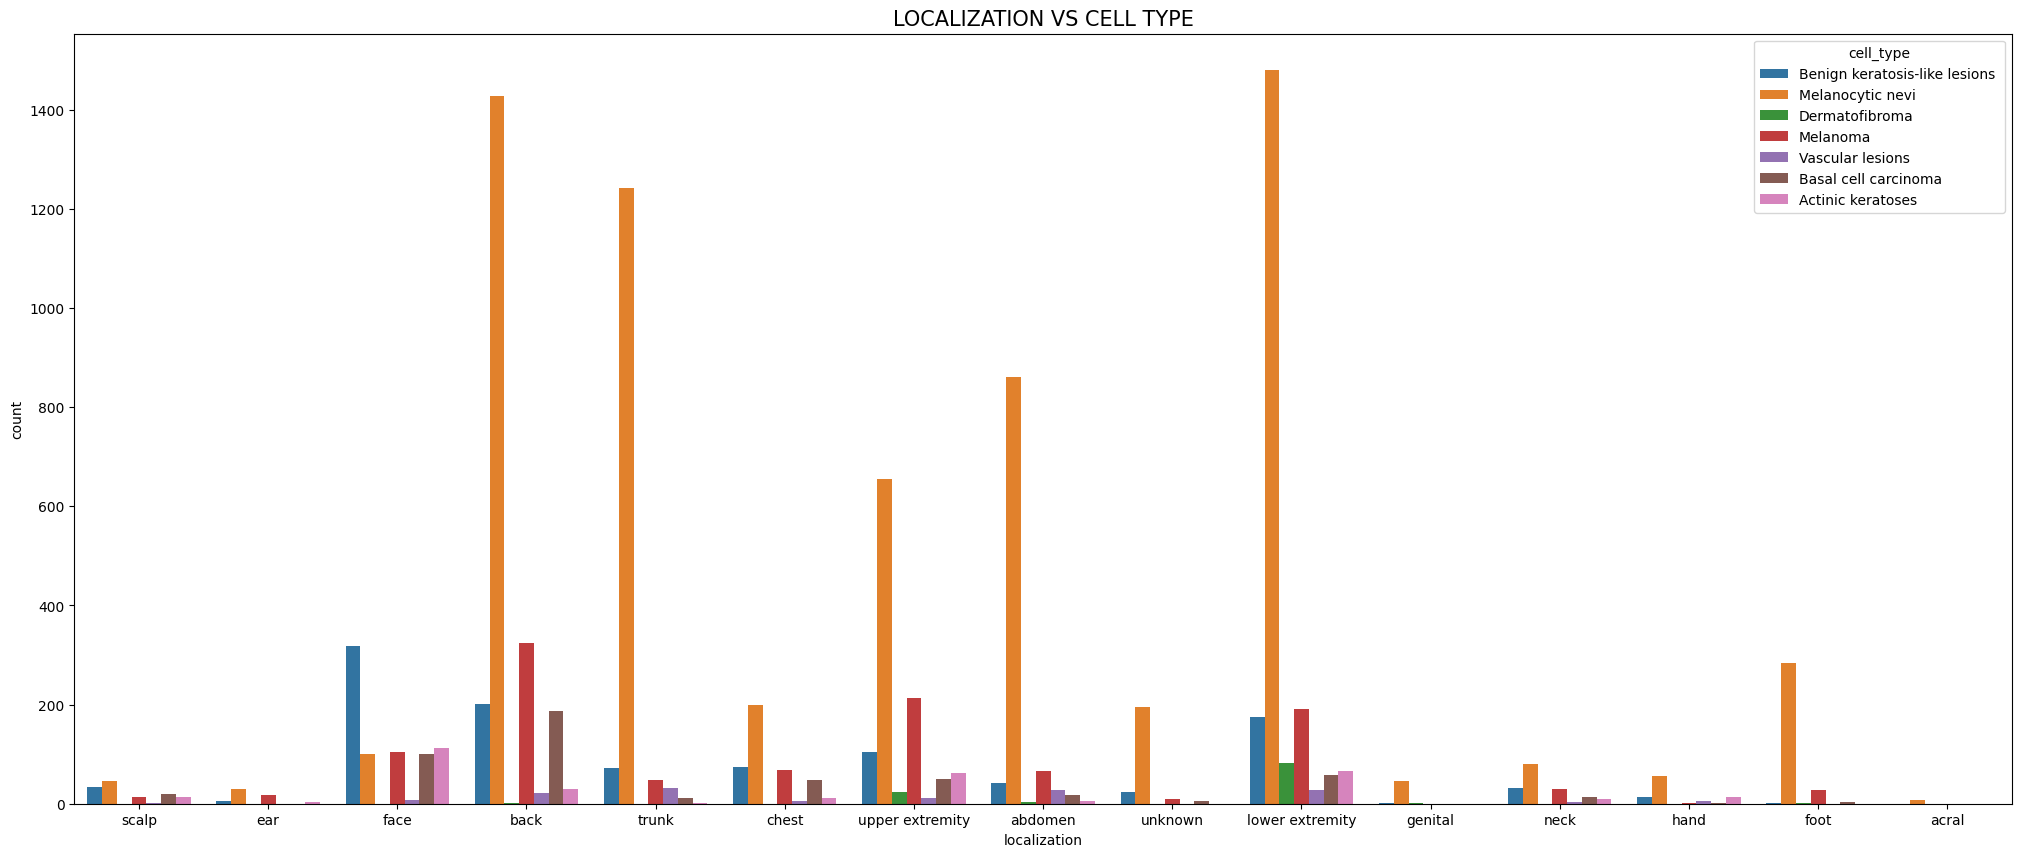

In [43]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(x='localization', hue='cell_type',data=tile_df)

<AxesSubplot: title={'center': 'LOCALIZATION VS CELL TYPE'}, xlabel='cell_type', ylabel='count'>

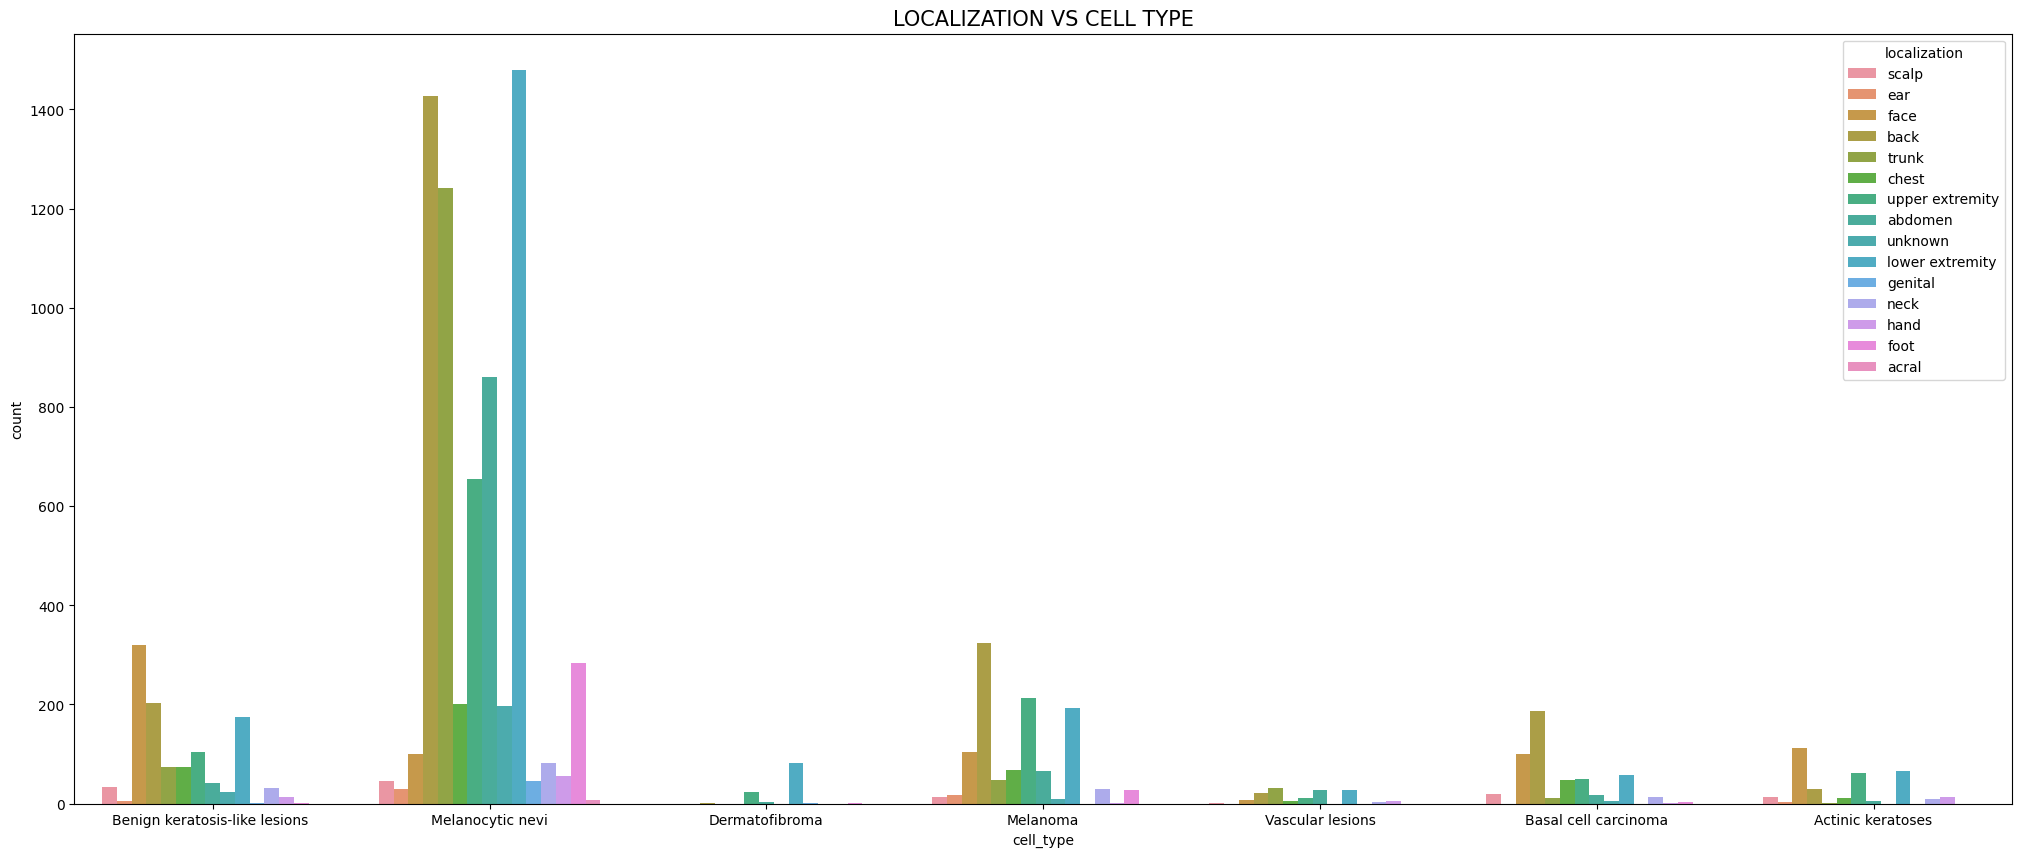

In [44]:
plt.figure(figsize=(25,10))
plt.title('LOCALIZATION VS CELL TYPE',fontsize = 15)
sns.countplot(x='cell_type', hue='localization',data=tile_df)

<AxesSubplot: title={'center': 'GENDER VS CELL TYPE'}, xlabel='count', ylabel='sex'>

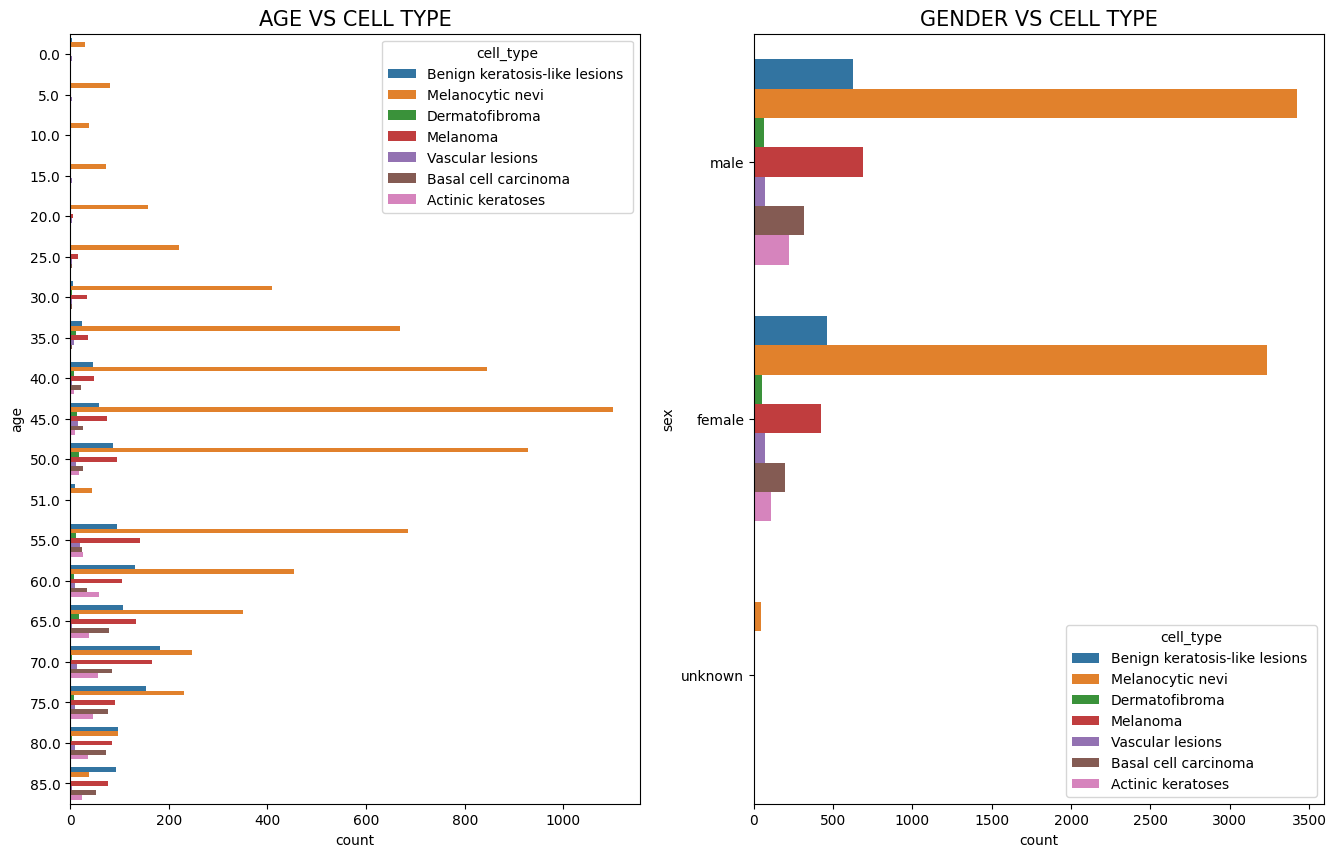

In [45]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.title('AGE VS CELL TYPE',fontsize = 15)
sns.countplot(y='age', hue='cell_type',data=tile_df)
plt.subplot(132)
plt.title('GENDER VS CELL TYPE',fontsize = 15)
sns.countplot(y='sex', hue='cell_type',data=tile_df)

# DATA PREPROCESSING

In [15]:
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [16]:
trial_data = tile_df.sample(500)
features = trial_data.drop(['cell_type_idx'], axis = 1)
label = trial_data['cell_type_idx']
features = np.asarray(features['image'].tolist())
label = label.to_numpy()

In [17]:
trial_data['cell_type'].value_counts()

Melanocytic nevi                 333
Melanoma                          58
Benign keratosis-like lesions     48
Basal cell carcinoma              27
Actinic keratoses                 16
Vascular lesions                   9
Dermatofibroma                     9
Name: cell_type, dtype: int64

In [18]:
# Normalizing the data
features = features/255
label = to_categorical(label,7)

In [19]:
aa = features
bb = label

In [20]:
xtr, xte, ytr, yte = train_test_split(aa, bb,
                              test_size=0.2, shuffle = True, random_state = 45)
xtr, xval, ytr, yval = train_test_split(xtr, ytr,
                              test_size=0.25, shuffle = True, random_state = 45)

In [36]:
print(xtr.shape)
print(xte.shape)
print(ytr.shape)
print(yte.shape)
print(xval.shape)
print(yval.shape)

(300, 224, 224, 3)
(100, 224, 224, 3)
(300, 7)
(100, 7)
(100, 224, 224, 3)
(100, 7)


In [ ]:
yte[:30]

In [40]:
yte_tc = to_categorical(yte,7)
ytr_tc = to_categorical(ytr,7)
yval_tc = to_categorical(yval,7)

# CNN TRIAL

### CNN1

In [145]:
from tensorflow.keras import regularizers

In [160]:
# CNN TRIAL

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


CNN1 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu',kernel_regularizer = regularizers.l2(0.005)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Conv2D(10, 3, activation='relu',kernel_regularizer = regularizers.l2(0.005)),
  Conv2D(10, 3, activation='relu', kernel_regularizer = regularizers.l2(0.005)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Flatten(),
  Dense(7, activation='softmax')
])

# Compile the model
CNN1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

CNNhist1 = CNN1.fit(xtr,ytr,
                        epochs=10,
                        batch_size = 3,
                        #steps_per_epoch=60, #len(xtr),
                        validation_data=(xval,yval),
                        validation_steps=len(xval))

Epoch 1/10


2022-11-23 07:33:45.256237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 1.3323 - accuracy: 0.6533

2022-11-23 07:34:07.856679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 24s 234ms/step - loss: 1.3323 - accuracy: 0.6533 - val_loss: 1.3409 - val_accuracy: 0.6500
Epoch 2/10
100/100 [==============================] - 3s 30ms/step - loss: 1.2900 - accuracy: 0.6600
Epoch 3/10
100/100 [==============================] - 3s 26ms/step - loss: 1.1977 - accuracy: 0.6600
Epoch 4/10
100/100 [==============================] - 3s 29ms/step - loss: 1.2407 - accuracy: 0.6600
Epoch 5/10
100/100 [==============================] - 17s 172ms/step - loss: 1.1142 - accuracy: 0.6600
Epoch 6/10
100/100 [==============================] - 3s 27ms/step - loss: 1.0778 - accuracy: 0.6600
Epoch 7/10
100/100 [==============================] - 3s 27ms/step - loss: 1.0629 - accuracy: 0.6600
Epoch 8/10
100/100 [==============================] - 4s 38ms/step - loss: 1.0629 - accuracy: 0.6600
Epoch 9/10
100/100 [==============================] - 12s 118ms/step - loss: 0.9900 - accuracy: 0.6667
Epoch 10/10
100/100 [==============================] -

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense


CNN1 = Sequential([
  Conv2D(32, kernel_size =(3,3), activation='relu', padding = 'same',input_shape=(224, 224, 3)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Conv2D(64, kernel_size =(3,3), activation='relu',padding = 'same',kernel_regularizer = regularizers.l2(0.001)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Conv2D(128, kernel_size =(3,3), activation='relu',padding = 'same', kernel_regularizer = regularizers.l2(0.001)),
  MaxPool2D(padding='same',pool_size=(2,2)),
  Dropout(0.2),
  Conv2D(128, kernel_size =(3,3), activation='relu',padding = 'same', kernel_regularizer = regularizers.l2(0.001)),
  Dropout(0.2),
  Flatten(),
  Dense(7, activation='softmax')
])

# Compile the model
CNN1.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

CNNhist1 = CNN1.fit(xtr,ytr,
                        epochs=10,
                        #batch_size = 3,
                        steps_per_epoch=len(xtr),
                        validation_data=(xval,yval),
                        validation_steps=len(xval))

Epoch 1/10


2022-11-23 07:52:53.732786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 1.9735 - accuracy: 0.6000

2022-11-23 07:53:06.660171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 15s 926ms/step - loss: 1.9735 - accuracy: 0.6000 - val_loss: 1.5160 - val_accuracy: 0.6500
Epoch 2/10
10/10 [==============================] - 6s 553ms/step - loss: 1.4712 - accuracy: 0.6600 - val_loss: 1.5220 - val_accuracy: 0.6500
Epoch 3/10
10/10 [==============================] - 4s 458ms/step - loss: 1.3762 - accuracy: 0.6600 - val_loss: 1.4813 - val_accuracy: 0.6500
Epoch 4/10
10/10 [==============================] - 4s 365ms/step - loss: 1.2712 - accuracy: 0.6600 - val_loss: 1.3572 - val_accuracy: 0.6500
Epoch 5/10
10/10 [==============================] - 4s 380ms/step - loss: 1.2273 - accuracy: 0.6600 - val_loss: 1.3501 - val_accuracy: 0.6500
Epoch 6/10
10/10 [==============================] - 4s 367ms/step - loss: 1.2188 - accuracy: 0.6600 - val_loss: 1.3483 - val_accuracy: 0.6500
Epoch 7/10
10/10 [==============================] - 4s 408ms/step - loss: 1.2066 - accuracy: 0.6600 - val_loss: 1.2854 - val_accuracy: 0.6500
Epoch 8/10
10/10

In [169]:
cnn_acc1 = CNN1.evaluate(xte,yte, verbose=0)[1]
print("CNN Test 1: accuracy = ",cnn_acc1*100,"%")

CNN Test 1: accuracy =  57.999998331069946 %


In [139]:
# Confusion Matrix
y_true = yte
y_pred = CNN1.predict(xte, verbose=1) 
y_pred.shape
# pred_classes = y_pred.argmax(axis=1)
# len(pred_classes)
# from sklearn.metrics import confusion_matrix
# #confusion_matrix(y_true.targets.np(), y_pred.argmax(dim=1))
# res = tf.math.confusion_matrix(y_true,y_pred)

1/4 [======>.......................] - ETA: 0s

2022-11-23 02:52:54.576911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 198ms/step


(100, 7)

In [140]:
y_pred = CNN1.predict(xte, verbose=1) 
qq = yte.argmax(axis=1)
qq[:10]
xx = y_pred.argmax(axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=qq, y_pred = xx)

In [143]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=qq, y_pred = xx)

array([[ 0,  0,  0,  0,  5,  0,  0],
       [ 0,  0,  0,  0,  8,  0,  0],
       [ 0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 57,  1,  0],
       [ 0,  0,  0,  0,  9,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0]])

In [70]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(qq, xx)
sklearn_accuracy

0.71

In [ ]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1, random_state=42)
>>> scores = cross_val_score(clf, X, y, cv=5)

In [52]:
y_true.shape == pred_classes.shape

True

In [73]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(CNN1, qq, xx,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)
# ,
#                              normalize=normalize)

ValueError: plot_confusion_matrix only supports classifiers

In [20]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred, labels = class_names)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

### CNN 2

In [ ]:
CNN2 = Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(7, activation='softmax')
])

# Compile the model
CNN2.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

CNNhist1 = CNN2.fit(xtr,ytr,
                        epochs=20,
                        steps_per_epoch=len(xtr),
                        validation_data=(xval,yval),
                        validation_steps=len(xval))

In [ ]:
cnn_acc2 = CNN2.evaluate(xte,yte, verbose=0)[1]
print("CNN Test 2: accuracy = ",cnn_acc2*100,"%")

### CNN 3

In [ ]:
CNN3 = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, activation='relu'),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(7, activation='softmax')
])

# Compile the model
CNN3.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5)

CNNhist3 = CNN3.fit(xtr,ytr,
                        epochs=20,
                        steps_per_epoch=len(xtr),
                        validation_data=(xval,yval),
                        validation_steps=len(xval),
                        callbacks= early_stopping)

Epoch 1/20


2022-11-18 22:50:03.183512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2399/2400 [============================>.] - ETA: 0s - loss: 1.2451 - accuracy: 0.6653

2022-11-18 22:51:59.609904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 131s 53ms/step - loss: 1.2448 - accuracy: 0.6654 - val_loss: 1.1696 - val_accuracy: 0.6650
Epoch 2/20
2400/2400 [==============================] - 124s 52ms/step - loss: 1.1786 - accuracy: 0.6667 - val_loss: 1.1688 - val_accuracy: 0.6650
Epoch 3/20
2400/2400 [==============================] - 116s 48ms/step - loss: 1.1720 - accuracy: 0.6667 - val_loss: 1.1962 - val_accuracy: 0.6650
Epoch 4/20
2400/2400 [==============================] - 135s 56ms/step - loss: 1.1950 - accuracy: 0.6662 - val_loss: 1.1835 - val_accuracy: 0.6650
Epoch 5/20
2400/2400 [==============================] - 114s 48ms/step - loss: 1.1720 - accuracy: 0.6667 - val_loss: 1.1816 - val_accuracy: 0.6650
Epoch 6/20
2400/2400 [==============================] - 108s 45ms/step - loss: 1.1716 - accuracy: 0.6667 - val_loss: 1.1750 - val_accuracy: 0.6650


In [ ]:
CNN3.evaluate(xte,yte, verbose=0)[1]

2022-11-18 23:06:50.016376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6587499976158142

In [ ]:
CNN = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(7, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
CNN.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

CNNhist = CNN.fit(xtr,ytr,
                        epochs=20,
                        steps_per_epoch=len(xtr),
                        validation_data=(xval,yval),
                        validation_steps=len(xval))

Epoch 1/20


2022-11-18 23:10:14.390770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - ETA: 0s - loss: 1.0750 - accuracy: 0.6650

2022-11-18 23:11:31.074846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 83s 34ms/step - loss: 1.0750 - accuracy: 0.6650 - val_loss: 1.0371 - val_accuracy: 0.6600
Epoch 2/20
2400/2400 [==============================] - 47s 20ms/step - loss: 0.9859 - accuracy: 0.6629 - val_loss: 0.9947 - val_accuracy: 0.6587
Epoch 3/20
2400/2400 [==============================] - 51s 21ms/step - loss: 0.9588 - accuracy: 0.6725 - val_loss: 1.0189 - val_accuracy: 0.6362
Epoch 4/20
2400/2400 [==============================] - 43s 18ms/step - loss: 0.8705 - accuracy: 0.6913 - val_loss: 0.9971 - val_accuracy: 0.6650
Epoch 5/20
2400/2400 [==============================] - 42s 18ms/step - loss: 0.8161 - accuracy: 0.7192 - val_loss: 0.9646 - val_accuracy: 0.6825
Epoch 6/20
2400/2400 [==============================] - 45s 19ms/step - loss: 0.7139 - accuracy: 0.7617 - val_loss: 1.1580 - val_accuracy: 0.5900
Epoch 7/20
2400/2400 [==============================] - 43s 18ms/step - loss: 0.6019 - accuracy: 0.7954 - val_loss: 1.1035 - val_accura

In [ ]:
CNN.evaluate(xte,yte, verbose=0)[1]

2022-11-18 23:27:26.212771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6487500071525574

In [ ]:
CNN = Sequential([
  Conv2D(16, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(7, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

# Compile the model
CNN.compile(loss="categorical_crossentropy", # changed to categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

CNNhist = CNN.fit(xtr,ytr,
                        epochs=20,
                        steps_per_epoch=len(xtr),
                        validation_data=(xval,yval),
                        validation_steps=len(xval))

Epoch 1/20


2022-11-18 23:29:27.621089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2397/2400 [============================>.] - ETA: 0s - loss: 1.2171 - accuracy: 0.6662

2022-11-18 23:30:42.095177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 81s 33ms/step - loss: 1.2177 - accuracy: 0.6658 - val_loss: 1.1673 - val_accuracy: 0.6650
Epoch 2/20
2400/2400 [==============================] - 49s 21ms/step - loss: 1.1738 - accuracy: 0.6662 - val_loss: 1.1723 - val_accuracy: 0.6650
Epoch 3/20
2400/2400 [==============================] - 40s 17ms/step - loss: 1.1567 - accuracy: 0.6667 - val_loss: 1.1805 - val_accuracy: 0.6650
Epoch 4/20
2400/2400 [==============================] - 43s 18ms/step - loss: 1.1542 - accuracy: 0.6667 - val_loss: 1.1653 - val_accuracy: 0.6650
Epoch 5/20
2400/2400 [==============================] - 38s 16ms/step - loss: 1.1524 - accuracy: 0.6667 - val_loss: 1.1775 - val_accuracy: 0.6650
Epoch 6/20
2400/2400 [==============================] - 39s 16ms/step - loss: 1.1483 - accuracy: 0.6667 - val_loss: 1.1737 - val_accuracy: 0.6650
Epoch 7/20
2400/2400 [==============================] - 40s 17ms/step - loss: 1.1468 - accuracy: 0.6667 - val_loss: 1.1708 - val_accura

In [ ]:
CNN.evaluate(xte,yte, verbose=0)[1]

2022-11-18 23:44:22.678652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6587499976158142

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

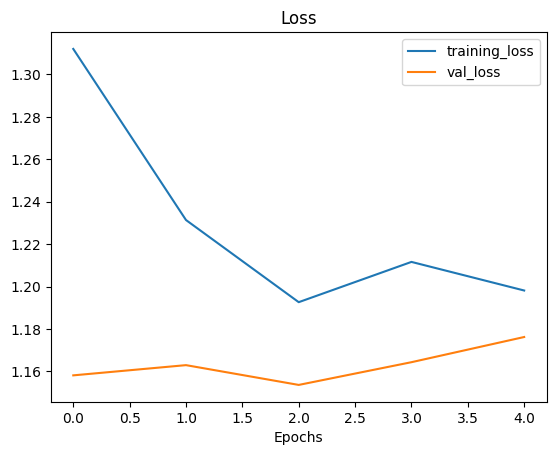

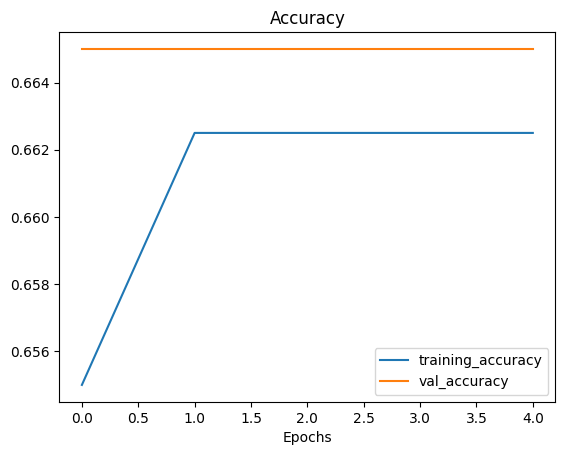

In [ ]:
plot_loss_curves(history_9)

# TRANSFER LEARNING TRIAL

In [ ]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true,y_pred, classes = None, figsize = (10,10), text_size=15):
  cm = confusion_matrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
  n_classes = cm.shape[0]

  # Making it pretty
  fig,ax = plt.subplots(figsize = figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

# Set labels to classes
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title = 'Confusion Matrix',
        xlabel = 'Predicted Label',
        ylabel= 'True Label',
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels = labels,
        yticklabels = labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min())/2

  # Plot the text on each
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
            horizontalalignment = 'center',
            color = 'white' if cm[i,j] > threshold else 'black',
            size = text_size)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

imagenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

# # New: EfficientNetB0 feature vector (version 2)
efficientnet_url2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224,224,3)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=7)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [ ]:
resnet_history = resnet_model.fit(xtr,ytr,
                                  epochs=20,
                                  steps_per_epoch=len(xtr),
                                  validation_data=(xval,yval),
                                  validation_steps=len(xval))
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                        #   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                        #                          experiment_name="resnet50V2")]) # name of log files

Epoch 1/20
2400/2400 [==============================] - 100s 39ms/step - loss: 0.3715 - accuracy: 0.8646 - val_loss: 1.4183 - val_accuracy: 0.6150
Epoch 2/20
2400/2400 [==============================] - 118s 49ms/step - loss: 0.3279 - accuracy: 0.8792 - val_loss: 1.1678 - val_accuracy: 0.6987
Epoch 3/20
2400/2400 [==============================] - 68s 29ms/step - loss: 0.2889 - accuracy: 0.8967 - val_loss: 1.1132 - val_accuracy: 0.7100
Epoch 4/20
2400/2400 [==============================] - 71s 30ms/step - loss: 0.2703 - accuracy: 0.9046 - val_loss: 1.2098 - val_accuracy: 0.7350
Epoch 5/20
2400/2400 [==============================] - 76s 31ms/step - loss: 0.2366 - accuracy: 0.9129 - val_loss: 1.4089 - val_accuracy: 0.7225
Epoch 6/20
2400/2400 [==============================] - 84s 35ms/step - loss: 0.2189 - accuracy: 0.9179 - val_loss: 1.4026 - val_accuracy: 0.6787
Epoch 7/20
2400/2400 [==============================] - 72s 30ms/step - loss: 0.2125 - accuracy: 0.9208 - val_loss: 1.4392

In [ ]:
plot_loss_curves(resnet_history)

NameError: name 'plot_loss_curves' is not defined

In [ ]:
resnet_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 7)                 14343     
                                                                 
Total params: 23,579,143
Trainable params: 14,343
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_accuracy = resnet_model.evaluate(xte,yte, verbose=0)[1]
print("Test: accuracy = ",resnet_accuracy*100,"%")

Test: accuracy =  74.87499713897705 %


In [ ]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=7)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(xtr,ytr, # only use 10% of training data
                                              epochs=20, # train for 5 epochs
                                              steps_per_epoch=len(xtr),
                                              validation_data=(xval,yval),
                                              validation_steps=len(xval)) #,
                                            #   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                            #                                          # Track logs under different experiment name
                            

Epoch 1/20


2022-11-19 20:55:09.976580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.6867

2022-11-19 20:56:30.219551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 116s 41ms/step - loss: 0.8903 - accuracy: 0.6867 - val_loss: 0.8328 - val_accuracy: 0.7200
Epoch 2/20
2400/2400 [==============================] - 75s 31ms/step - loss: 0.6818 - accuracy: 0.7475 - val_loss: 0.7601 - val_accuracy: 0.7350
Epoch 3/20
2400/2400 [==============================] - 76s 32ms/step - loss: 0.6027 - accuracy: 0.7821 - val_loss: 0.8094 - val_accuracy: 0.7262
Epoch 4/20
2400/2400 [==============================] - 228s 95ms/step - loss: 0.5415 - accuracy: 0.7983 - val_loss: 0.7825 - val_accuracy: 0.7525
Epoch 5/20
2400/2400 [==============================] - 260s 108ms/step - loss: 0.5007 - accuracy: 0.8179 - val_loss: 0.7703 - val_accuracy: 0.7212
Epoch 6/20
2400/2400 [==============================] - 199s 83ms/step - loss: 0.4617 - accuracy: 0.8304 - val_loss: 0.8188 - val_accuracy: 0.7075
Epoch 7/20
2400/2400 [==============================] - 82s 34ms/step - loss: 0.4346 - accuracy: 0.8404 - val_loss: 0.7324 - val_a

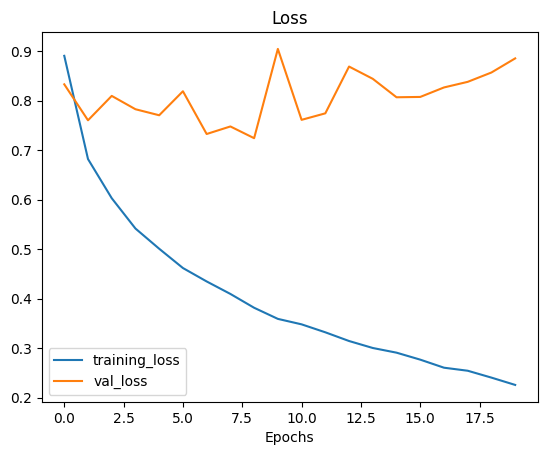

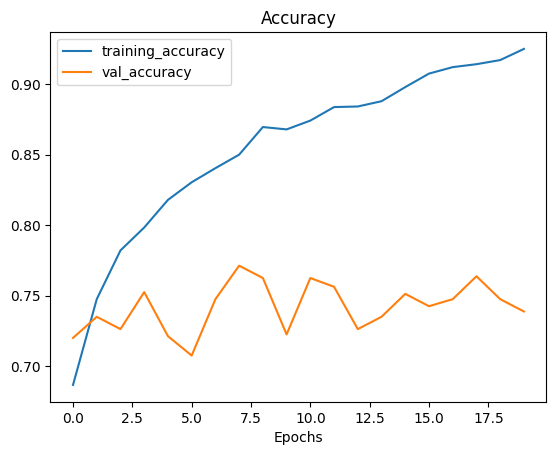

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,531
Trainable params: 8,967
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
accuracy = efficientnet_model.evaluate(xte, yte, verbose=0)[1]
print("Test: accuracy = ",accuracy*100,"%")

2022-11-19 21:49:35.077213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test: accuracy =  75.49999952316284 %


In [ ]:
efficientnet_model2 = create_model(model_url=efficientnet_url2, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=7)

# Compile EfficientNet model
efficientnet_model2.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history2 = efficientnet_model2.fit(xtr,ytr, # only use 10% of training data
                                              epochs=20, # train for 5 epochs
                                              steps_per_epoch=len(xtr),
                                              validation_data=(xval,yval),
                                              validation_steps=len(xval)) #,
                                            #   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                            #                                          # Track logs under different experiment name
                            

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
plot_loss_curves(efficientnet_history2)

NameError: name 'efficientnet_history2' is not defined

In [ ]:
# Mobile Net
base_model = keras.applications.MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))
base_model.trainable = False
inputs = keras.Input(shape=(224,224,3))
x = base_model(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(class_names),activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=x, name="SkinLesion_MobileNet")

In [ ]:
model.summary()

Model: "LeafDisease_MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 3,236,039
Trainable params: 7,1

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5) # stops after 5 rounds of no improvements
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [ ]:
history = model.fit(xtr,ytr,
          validation_data=(xval,yval),
          epochs=40,
          steps_per_epoch=len(xtr),
          validation_steps=len(xval),
          callbacks = early_stopping
         )

Epoch 1/40


/Users/favechibueze/miniforge3/envs/mike_env/lib/python3.8/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-11-19 00:50:47.192665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2397/2400 [============================>.] - ETA: 0s - loss: 0.9758 - categorical_accuracy: 0.6863

2022-11-19 00:51:54.463195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 102s 32ms/step - loss: 0.9782 - categorical_accuracy: 0.6863 - val_loss: 0.8800 - val_categorical_accuracy: 0.7063
Epoch 2/40
2400/2400 [==============================] - 49s 21ms/step - loss: 0.6969 - categorical_accuracy: 0.7529 - val_loss: 0.8563 - val_categorical_accuracy: 0.7025
Epoch 3/40
2400/2400 [==============================] - 42s 17ms/step - loss: 0.5811 - categorical_accuracy: 0.7821 - val_loss: 0.8710 - val_categorical_accuracy: 0.7050
Epoch 4/40
2400/2400 [==============================] - 42s 18ms/step - loss: 0.5117 - categorical_accuracy: 0.8058 - val_loss: 0.9285 - val_categorical_accuracy: 0.7175
Epoch 5/40
2400/2400 [==============================] - 43s 18ms/step - loss: 0.4536 - categorical_accuracy: 0.8296 - val_loss: 0.8554 - val_categorical_accuracy: 0.7312
Epoch 6/40
2400/2400 [==============================] - 42s 18ms/step - loss: 0.4365 - categorical_accuracy: 0.8408 - val_loss: 0.9396 - val_categorical_accurac

In [ ]:
accuracy = model.evaluate(xte,yte, verbose=0)[1]

/Users/favechibueze/miniforge3/envs/mike_env/lib/python3.8/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2022-11-19 01:55:32.490062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [21]:
from tensorflow.keras import layers
data_aug = keras.Sequential(
   [
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

2022-11-23 09:54:36.700638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-23 09:54:36.702625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
base_model = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3))
base_model.trainable = False
inputs = keras.Input(shape=(224,224,3))
x = data_aug(inputs,training=False)

In [23]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(7)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                             

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

epochs = 5
model.fit(xtr,ytr,
          epochs=epochs, 
          validation_data=(xval,yval))

Epoch 1/5


2022-11-23 09:54:59.130186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-23 09:55:00.859636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 8.0267 - accuracy: 0.1000

2022-11-23 09:55:09.193044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 15s 1s/step - loss: 8.0267 - accuracy: 0.1000 - val_loss: 3.1923 - val_accuracy: 0.1800
Epoch 2/5
10/10 [==============================] - 9s 921ms/step - loss: 6.9638 - accuracy: 0.4733 - val_loss: 13.1125 - val_accuracy: 0.6700
Epoch 3/5
10/10 [==============================] - 11s 1s/step - loss: 13.2681 - accuracy: 0.6367 - val_loss: 13.3596 - val_accuracy: 0.6700
Epoch 4/5
10/10 [==============================] - 10s 990ms/step - loss: 13.1699 - accuracy: 0.6333 - val_loss: 13.1420 - val_accuracy: 0.6700
Epoch 5/5
10/10 [==============================] - 7s 769ms/step - loss: 13.0135 - accuracy: 0.6333 - val_loss: 11.7929 - val_accuracy: 0.6700


In [ ]:
batch_size=10
epoch =10
steps_per_epoch = 54000//batch_size
validation_steps = 6000// batch_size

In [33]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 5
model.fit(xtr,ytr,
          epochs=epochs, 
          validation_data=(xval,yval))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 7)                 14343     
                                                             

2022-11-23 10:23:40.090219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 1.9359 - accuracy: 0.6333

2022-11-23 10:24:47.988616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 77s 7s/step - loss: 1.9359 - accuracy: 0.6333 - val_loss: 1.9357 - val_accuracy: 0.6700
Epoch 2/5
10/10 [==============================] - 47s 5s/step - loss: 1.9358 - accuracy: 0.6333 - val_loss: 1.9356 - val_accuracy: 0.6700
Epoch 3/5
10/10 [==============================] - 42s 4s/step - loss: 1.9358 - accuracy: 0.6333 - val_loss: 1.9355 - val_accuracy: 0.6700
Epoch 4/5
10/10 [==============================] - 45s 5s/step - loss: 1.9357 - accuracy: 0.6333 - val_loss: 1.9354 - val_accuracy: 0.6700
Epoch 5/5
10/10 [==============================] - 48s 5s/step - loss: 1.9356 - accuracy: 0.6333 - val_loss: 1.9353 - val_accuracy: 0.6700


In [34]:
accuracy = model.evaluate(xte,yte, verbose=0)[1]

In [35]:
accuracy

0.7599999904632568

In [37]:
y_pred = model.predict(xte, verbose=1) 
qq = yte.argmax(axis=1)
#qq[:10]
xx = y_pred.argmax(axis=1)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=qq, y_pred = xx)

2022-11-23 10:53:58.616861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 14s 1s/step


array([[ 0,  0,  0,  4,  0,  0],
       [ 0,  0,  0,  6,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  0, 76,  0,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  3,  0,  0]])

In [42]:
import xgboost as xgb
from xgboost import XGBClassifier

In [48]:
xte_tf =model.predict(xte)
xte_tf = xgb.DMatrix(xte_tf)

4/4 [==============================] - 5s 914ms/step


In [49]:
y_pred = model.predict(xte_tf)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1)

ValueError: Failed to find data adapter that can handle input: <class 'xgboost.core.DMatrix'>, <class 'NoneType'>

In [45]:
import pickle

In [46]:
model_xgb =  pickle.load(open("cnn_xgboost_final.pickle.dat", "rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'cnn_xgboost_final.pickle.dat'

# CONFUSION MATRIX

In [94]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from IPython.display import Image

In [101]:
phy_dev = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs available:", len(phy_dev))
#tf.config.experimental.set_memory_growth(phy_dev[0], True)

Num GPUs available: 1


In [103]:
model = tf.keras.applications.MobileNet()

17225924/17225924 [==============================] - 37s 2us/step


In [104]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [105]:
def prepare_image(img):
    #img = tile_df['image']
    img_array = image.img_to_array(img)
    img_array_exp_dims = np.expand_dims(img_array,axis =0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_exp_dims)


In [125]:
processedimg = prepare_image(tile_df['image'][5])

In [126]:
pred = model.predict(processedimg)

1/1 [==============================] - 0s 88ms/step


In [127]:
res = imagenet_utils.decode_predictions(pred)
res

[[('n02786058', 'Band_Aid', 0.21312267),
  ('n03692522', 'loupe', 0.14293894),
  ('n07753113', 'fig', 0.10867794),
  ('n04597913', 'wooden_spoon', 0.09898834),
  ('n07718747', 'artichoke', 0.09304452)]]

# MODEL 1

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(input_shape=(224, 224)),
    tf.keras.layers.Dense(units= 16, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 128, kernel_initializer = 'uniform', activation = 'relu'),
    #tf.keras.layers.Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0008,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

# fit the keras model on the dataset
epochs = 40
history = model.fit(x_train,
                    y_train, 
                    batch_size = 100, 
                    epochs = epochs,
                    validation_data = (x_val,y_val)) #, # verbose = 0)


Epoch 1/40


2022-11-16 17:26:25.019053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.4080 - accuracy: 0.6356

2022-11-16 17:26:32.462010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 9s 436ms/step - loss: 1.4080 - accuracy: 0.6356 - val_loss: 1.2141 - val_accuracy: 0.6625
Epoch 2/40
16/16 [==============================] - 3s 217ms/step - loss: 1.1472 - accuracy: 0.6687 - val_loss: 1.1670 - val_accuracy: 0.6625
Epoch 3/40
16/16 [==============================] - 3s 188ms/step - loss: 1.1228 - accuracy: 0.6687 - val_loss: 1.1560 - val_accuracy: 0.6625
Epoch 4/40
16/16 [==============================] - 2s 97ms/step - loss: 1.1129 - accuracy: 0.6687 - val_loss: 1.1392 - val_accuracy: 0.6625
Epoch 5/40
16/16 [==============================] - 2s 109ms/step - loss: 1.0955 - accuracy: 0.6687 - val_loss: 1.1289 - val_accuracy: 0.6625
Epoch 6/40
16/16 [==============================] - 2s 108ms/step - loss: 1.0810 - accuracy: 0.6687 - val_loss: 1.0965 - val_accuracy: 0.6625
Epoch 7/40
16/16 [==============================] - 2s 99ms/step - loss: 1.0553 - accuracy: 0.6687 - val_loss: 1.0767 - val_accuracy: 0.6625
Epoch 8/40
16/16 [=

In [ ]:
accuracy = model.evaluate(x_test, y_test, verbose=0)[1]
print("Test: accuracy = ",accuracy*100,"%")

2022-11-16 17:03:58.861292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test: accuracy =  65.49999713897705 %


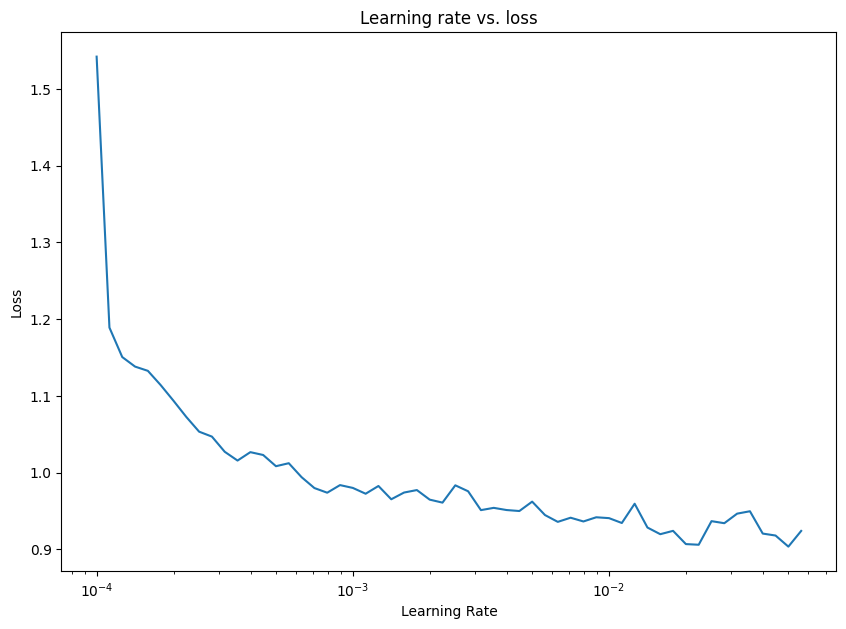

In [ ]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

<AxesSubplot: title={'center': 'Rates'}>

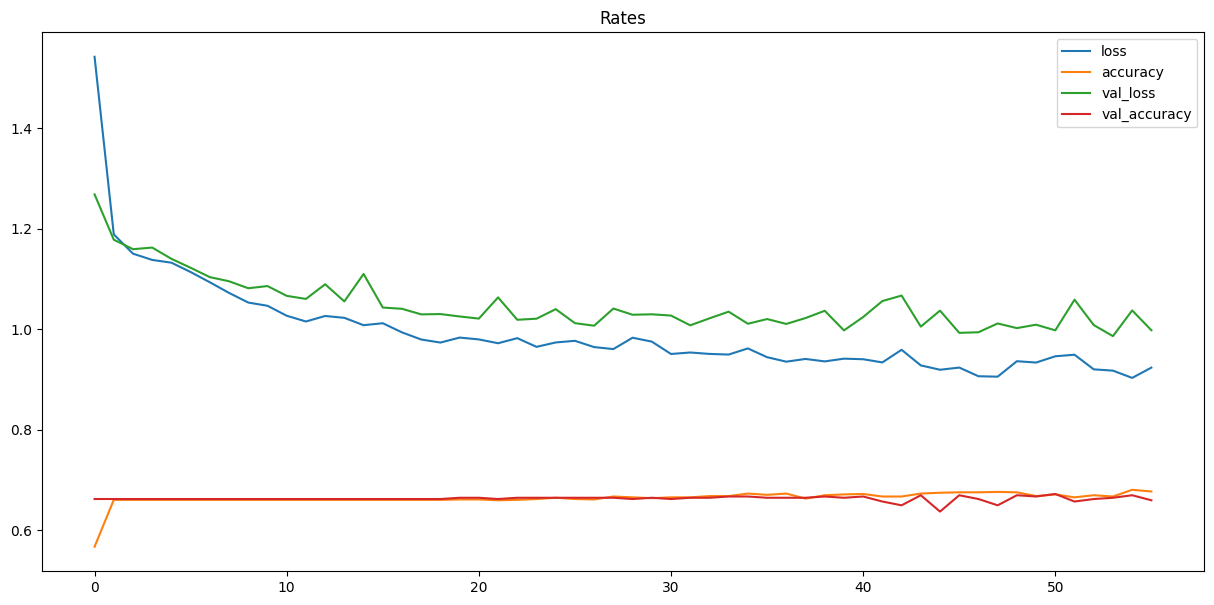

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(title='Rates', figsize=(15, 7))

In [ ]:
tf.random.set_seed(22)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 8, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 16, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    #tf.keras.layers.Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train,
                    y_train, 
                    batch_size = 100, 
                    epochs = 90,
                    validation_data = (x_val,y_val)) #, # verbose = 0)

# MODEL 2

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 16, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    #tf.keras.layers.Dense(units= 512, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model1.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

# fit the keras model on the dataset
epochs = 100
history1 = model1.fit(x_train,
                    y_train, 
                    batch_size = 100, 
                    epochs = epochs,
                    validation_data = (x_val,y_val)) #, # verbose = 0)

Epoch 1/100


2022-11-16 16:56:51.010700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.8050 - accuracy: 0.4750

2022-11-16 16:56:53.932435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 4s 253ms/step - loss: 1.8050 - accuracy: 0.4750 - val_loss: 1.3370 - val_accuracy: 0.6625
Epoch 2/100
12/12 [==============================] - 1s 123ms/step - loss: 1.2575 - accuracy: 0.6608 - val_loss: 1.1970 - val_accuracy: 0.6625
Epoch 3/100
12/12 [==============================] - 1s 107ms/step - loss: 1.1821 - accuracy: 0.6608 - val_loss: 1.1892 - val_accuracy: 0.6625
Epoch 4/100
12/12 [==============================] - 1s 80ms/step - loss: 1.1609 - accuracy: 0.6608 - val_loss: 1.1823 - val_accuracy: 0.6625
Epoch 5/100
12/12 [==============================] - 1s 101ms/step - loss: 1.1564 - accuracy: 0.6608 - val_loss: 1.1542 - val_accuracy: 0.6625
Epoch 6/100
12/12 [==============================] - 1s 88ms/step - loss: 1.1347 - accuracy: 0.6608 - val_loss: 1.1479 - val_accuracy: 0.6625
Epoch 7/100
12/12 [==============================] - 1s 93ms/step - loss: 1.1267 - accuracy: 0.6608 - val_loss: 1.1405 - val_accuracy: 0.6625
Epoch 8/100
12

In [ ]:
accuracy1 = model.evaluate(x_test, y_test, verbose=0)[1]
print("Test: accuracy = ",accuracy1*100,"%")

Test: accuracy =  65.24999737739563 %


In [ ]:
# Plot the learning rate versus the loss
lrs1 = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs1, history1.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

In [ ]:
import pandas as pd
pd.DataFrame(history1.history).plot(title='Rates', figsize=(15, 7))

In [ ]:
tf.random.set_seed(42)

model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(units= 32, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 128, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units= 256, kernel_initializer = 'uniform', activation = 'relu'),
    tf.keras.layers.Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax')])

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

# compile the keras model
model1.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch/20))

# fit the keras model on the dataset
history1 = model1.fit(x_train, 
                      y_train, 
                      batch_size = 10, 
                      epochs = 65, 
                      verbose = 0,
                      callbacks = [lr_scheduler])

accuracy = model1.evaluate(x_val, y_val, verbose=0)[1]
print("Test: accuracy = ",accuracy*100,"%")



In [ ]:
lrs = 1e-3 * (10**(tf.range(65)/20))
plt.semilogx(lrs,history1.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Finding the ideal learning rate')

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true,y_pred, classes = None, figsize = (10,10), text_size=15):
  cm = confusion_matrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
  n_classes = cm.shape[0]

  # Making it pretty
  fig,ax = plt.subplots(figsize = figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

# Set labels to classes
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title = 'Confusion Matrix',
        xlabel = 'Predicted Label',
        ylabel= 'True Label',
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels = labels,
        yticklabels = labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position('bottom')
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # Set threshold for different colors
  threshold = (cm.max() + cm.min())/2

  # Plot the text on each
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
            horizontalalignment = 'center',
            color = 'white' if cm[i,j] > threshold else 'black',
            size = text_size)

In [ ]:
y_probs = model.predict(y_test) 
y_preds = y_probs .argmax(axis=1)

In [ ]:
class_names = ['Benign keratosis-like lesions ', 'Melanocytic nevi','Dermatofibroma', 
               'Melanoma', 'Vascular lesions','Basal cell carcinoma', 'Actinic keratoses']
make_confusion_matrix(y_true=y_test, 
                      y_pred = y_preds, 
                      classes = class_names,
                      figsize = (13,13),
                      text_size = 10)

# TRANSFER LEARNING

#CNN

In [ ]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
input_shape = (224, 224, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)